In [2]:
import pyNSRDB
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import requests
import pytz
from timezonefinder import TimezoneFinder
import pvlib
from pvlib import pvsystem, location, temperature, modelchain, solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hybrid_tea_model_photon import hybrid_tea_model_photon
import warnings
from scipy.interpolate import interp1d
import math

warnings.filterwarnings('ignore')

################################################################# Retrieve TMY data ###################################################################

#%% System Constants and Parameters 
#key = 'luke_test' # Define a key to associate with data
#save_path = 'D:\Models\8760_ESS' # Define path to save data/figures to
interval = 30
interpolating = True
# TMY Data Setup and PVlib Location

# gets coordinates given a location - default Page AZ
def get_location_coordinates(plant_location = "Page, Arizona"):
        geolocator = Nominatim(user_agent="photonvault")
        try:
            location = geolocator.geocode(plant_location)
            return location.latitude, location.longitude 
        except GeocoderTimedOut as e:
            print("error: geocode failed :( try another location "%(plant_location, e.message))

# retrieves tmy data from NSRDB for given coordinates and year
def get_tmy_data(lat, lon, year, interval, api_key = "Ay1bsdBsLr9ObP8gfuatHzoEU2pmOSXfwVWUcXCp"):
    attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
    leap_year = 'false'
    interval = interval
    utc = 'true'
    your_name = 'NSTTF'
    reason_for_use = 'tea_analysis'
    your_affiliation = 'Sandia'
    your_email = 'johnsontaylor@ufl.edu'
    mailing_list = 'false'
    url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    data = pd.read_csv(url,nrows=3)
    data = pd.read_csv(url, header=2)
    return data

def get_timezone(latitude, longitude):
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)
    return timezone_str
    
# location_coods = get_location_coordinates("Page, Arizona") < blocked by firewall, proxy problem (?) resolve later 
# latitude, longitude  = location_coods[0], location_coods[1]
latitude, longitude = 36.9140854, -111.4551159
year = 2019
data = get_tmy_data(latitude, longitude, year,interval)
DHI,DNI,GHI = data['DHI'],data['DNI'], data['GHI']                                                 # solar availability data
theta_z = data['Solar Zenith Angle']                                                               # solar zenith angle 
amb_temp = data['Temperature']
year,month,day,hour,minute = data['Year'],data['Month'], data['Day'], data['Hour'],data['Minute']  # time data 
tz = get_timezone(latitude,longitude)

In [72]:
############################################################### Define study parameters ###############################################################
if interpolating:
    no_ts = 4
    timeunit = '1/4 Hour'
else: 
    no_ts = 1
    timeunit = 'Hour'

# Analysis Period 
period = 24*365*no_ts # Number of time steps for simulation

# Grid Load Profile - Simulated
hrs = np.arange(0, period, 1) # Setup interger hours of analysis
load = [2.5e3]*8760*no_ts # Wh

# CSP System Definition  
n_collectors = 5e2  # Number of solar collectors
area_per_collector = 15  # Area per collector [m^2]
collecting_area = n_collectors * area_per_collector  # Total collecting area [m2]
eff_csp = 0.50  # CSP system efficiency
tilt = latitude # add in function later to optimize w bias towards winter

# TES System Definition
eff_particleheater = 0.99 # Particle Heater efficiency
tes_loss_rate = 0.020833333/100  # TES energy loss rate per hour
tes_capacity = 1e6 # TES capacity [kWh_th]
tes_discharge_efficiency = 0.4
tes_charge_efficiency = 0.95  # TES charge efficiency
tes_stored = 0 # Starting TES charge [kWh]
min_tes_output = 10  # Minimum TES output in kW_e 
maximum_hourly_tes_output = 1e4  # Maximum TES output in kW_e 
tes_min_threshold = 20  # Minimum energy level in kWh to maintain in TES

# PV System Setup
PV_AC_Rating = 5e6 # [W]
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter_parameters = {
    'Paco': PV_AC_Rating,  # AC power output [W]
    'Pdco': PV_AC_Rating * 2,  # DC power input [W]
    'Vdco': 480,  # DC voltage [V]
    'Pnt': 0.5,  # Night time power [W]
    'Pso': 0,  # Self-consumption power [W]
    'C0': -0.00025,
    'C1': 0.0001,
    'C2': 0.02,
    'C3': -0.04
}

#%% TEA Constants & Parameters 
C_PV = 890 # Cost of PV [$/kW]
C_CSP = 0 # Cost of CSP [$/collector]
C_TES = 0 # Cost per capacity of TES [$/kWh_th]
C_PB = 0 # Cost of power block [$/kW]

# O&M Defined Input
C_OM_TES = 15.0 # [$/kW-year] TES O&M cost
C_OM_CSP = 66 - C_OM_TES # [$/kW-year] CSP O&M cost
C_OM_PV = 22 # [$/kW-year] PV O&M cost

# TEA PARAMETERS
L = 30 # [yrs] Operational Life
n = 30 # [yrs] Analysis period
tax = 0.257 # [frac] State and federal tax rate
inflation = 0.028 # [frac] Inflation rate
ITC = 0.0 # [frac] Internal tax credit 
insurance = 0.004   #[frac] Insurance rate
property_tax = 0.0084 # [frac] Property Tax Rate
I = 0.08 # [frac] Nominal Interest rate 
COE = 0.13 # [frac] Cost of equity 
DF=0.5 #  [frac] Debt fraction
MACRS_yrs = 7 # [yrs] MACRS Depreciation Period 
PVD = 0.73281282777303 # [frac] Present Value of Depreciation based on MACRS_yrs
esc = 0.02 # [frac] Escalation rate

In [74]:
##################################################################### Performance Model ################################################################

# PV simulation 
tmy_data = pd.DataFrame({
    'dhi': DHI,
    'dni': DNI,
    'ghi': GHI,
    'Solar Zenith Angle': theta_z,
    'Year': year,
    'Month': month,
    'Day': day,
    'Hour': hour,
    'Minute': minute
})

tmy_data['DateTime'] = pd.to_datetime(tmy_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
tmy_data.set_index('DateTime', inplace=True)
tmy_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)


site = pvlib.location.Location(latitude, longitude, tz=tz)
if not tmy_data.index.tz:
    tmy_data.index = tmy_data.index.tz_localize('UTC').tz_convert(tz)
dni_data = tmy_data['dni'][:period]  # Direct Normal Irradiance data [W/m^2]
system = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=180,
                                 module_parameters=module,
                                 modules_per_string=1,
                                 inverter_parameters=inverter_parameters,
                                 temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'])
mc = pvlib.modelchain.ModelChain(system, site, aoi_model='physical', spectral_model='no_loss', ac_model='sandia')
mc.run_model(tmy_data)
hourly_pv_output = mc.results.ac / 1000  # Hourly PV output [kW]
hourly_pv_output=hourly_pv_output[:period]

# CSP Simulation
#csp_thermal_power = dni_data/1000 * collecting_area * eff_csp  # CSP thermal power [kW]

#### Collector params / physical constants 
n1 = np.array([1,1.33]) # air, water
n2 = 1.585 # polycarbonate 
absorption_fp = 0.95
reflection = 0.92
optical_efficiency = 0.95
transmission_glass = 0.92
absorption_collector = 0.95
surface_temp = 4.93e2 # K # does temp variation throughout day matter? 
emissivity = 0.07 
sigma = 5.67e-8 # W/m2K4

    #********************************* azimuth (east-west orientation of panel) *********************************
def optimal_azimuth(latitude):
    if latitude > 0:
        # Northern Hemisphere
        return 180  # true south
    else:
        # Southern Hemisphere
        return 0    # true north
        
    #******************************************* angle of incidence ******************************************
def calculate_AOI(tmy_data, latitude, longitude, tilt): # array of total irradiance values on the tilted surface for each hour
    
    azimuth = optimal_azimuth(latitude)
    solar_position = solarposition.get_solarposition(tmy_data.index, latitude, longitude)
    zenith_angle = solar_position['zenith']
    azimuth_angle = solar_position['azimuth']
    AOI = pvlib.irradiance.aoi(tilt, azimuth, zenith_angle, azimuth_angle)
    AOI = np.deg2rad(AOI)
    return AOI,zenith_angle # returns in radians 


def calculate_transmission_coefficient(AOI, n1, n2):
    trsmn1 = []
    trsmn2 = []
    
    for aoi in AOI:
        theta = aoi
        n1cos1 = n1[0] * np.cos(theta)
        n2sqrt1 = n2 * np.sqrt(1 - (n1[0]**2 / n2**2) * np.sin(theta)**2)
        # Fresnel reflection coefficients for s- and p-polarization for n1[0]
        Rs1 = ((n1cos1 - n2sqrt1) ** 2) / ((n1cos1 + n2sqrt1) ** 2)
        Rp1 = ((n1cos1 - n2sqrt1) ** 2) / ((n1cos1 + n2sqrt1) ** 2)
        # Average reflectance for n1[0]
        Ravg1 = (Rs1 + Rp1) / 2
        # Transmission coefficient for n1[0]
        transmission_fp1 = (1 - Ravg1)**2
        trsmn1.append(transmission_fp1)

        n1cos2 = n1[1] * np.cos(theta)
        n2sqrt2 = n2 * np.sqrt(1 - (n1[1]**2 / n2**2) * np.sin(theta)**2)
        # Fresnel reflection coefficients for s- and p-polarization 
        Rs2 = ((n1cos2 - n2sqrt2) ** 2) / ((n1cos2 + n2sqrt2) ** 2)
        Rp2 = ((n1cos2 - n2sqrt2) ** 2) / ((n1cos2 + n2sqrt2) ** 2)
        # Average reflectance 
        Ravg2 = (Rs2 + Rp2) / 2
        # Transmission coefficient 
        transmission_fp2 = (1 - Ravg2)**2
        trsmn2.append(transmission_fp2)

    transmission_fp = np.array(trsmn1) * np.array(trsmn2)
    
    return transmission_fp

def csp_performance_simulation(dni_data,amb_temp,tilt): 
    total_collection_area = n_collectors*area_per_collector
    pipe_transmission_losses = 22*(250 - amb_temp)/225
    
    # optics calculations 
    AOI,zenith_angle = calculate_AOI(tmy_data, latitude, longitude, tilt) # radians
    transmission_fp = calculate_transmission_coefficient(AOI, n1, n2)
    sol_zen_ang = zenith_angle
    acceptance_angle = np.abs(tilt - sol_zen_ang)
    acceptance_angle = np.where(acceptance_angle > 30, 0, 1)
    collection_fraction = transmission_fp*absorption_fp*reflection*optical_efficiency*transmission_glass*absorption_collector*acceptance_angle*(np.cos((AOI)))
    incident_power = collection_fraction*total_collection_area*dni_data
    energy_emitted_from_surface = sigma*emissivity*surface_temp**4 
    radiated_power = energy_emitted_from_surface*total_collection_area*(0.382/0.66) 
    net_power_after_radlosses = incident_power - radiated_power 
    net_power_received = [max(0, net - pipe) for net, pipe in zip(net_power_after_radlosses, pipe_transmission_losses)]
    net_power_received = np.array(incident_power)
    flux = net_power_received/total_collection_area
    csp_thermal_power = flux*total_collection_area/1000 # kW
    total_losses = np.sum(pipe_transmission_losses) + radiated_power
    #print(f'New model: {np.sum(csp_thermal_power)}')
    #print(f'Losses from pipe transmission and radiated power: {total_losses}')
    
    return csp_thermal_power,AOI, sol_zen_ang,collection_fraction,acceptance_angle
    
#csp_thermal_power = dni_data/1000 * collecting_area * eff_csp  # CSP thermal power [kW]
#print(f'Old model: {np.sum(csp_thermal_power)}')    
csp_thermal_power,AOI, sol_zen_ang,collection_fraction,acceptance_angle = csp_performance_simulation(dni_data,amb_temp,tilt)

def interpolate_performance_data(arr):
    new_indices = np.linspace(0, len(arr) - 1, 2 * len(arr))
    interpolated_data = np.interp(new_indices, np.arange(len(arr)), arr)
    return interpolated_data

if interpolating:
    csp_thermal_power = interpolate_performance_data(csp_thermal_power)
    hourly_pv_output = interpolate_performance_data(hourly_pv_output)
    amb_temp = interpolate_performance_data(amb_temp)
    dni_data = interpolate_performance_data(dni_data)

In [82]:
############################################################# Energy Balance Simulation ##############################################################

# Thermal to electric conversion efficiency 
ambient_temps = [-5, 5, 10, 15, 20, 25, 30]
conversion_rates = [0.27972028, 0.27972028, 0.27972028, 0.307692308, 0.323624595, 0.374531835, 0.374531835]

def th2e_efficiency(T):
    if T <= ambient_temps[0]:
        return conversion_rates[0]
    elif T >= ambient_temps[-1]:
        return conversion_rates[-1]
    else:
        # finds the interval relevant to input temp
        for i in range(len(ambient_temps) - 1):
            if ambient_temps[i] <= T < ambient_temps[i + 1]:
                # linear interpolation to get the 
                eta_val = (conversion_rates[i] * (ambient_temps[i + 1] - T) +
                           conversion_rates[i + 1] * (T - ambient_temps[i])) / (ambient_temps[i + 1] - ambient_temps[i])
                return eta_val

grid_power_required = np.zeros(period)
yearly_tes_stored = np.zeros(period)
annual_energy_demand = np.sum(load)
excess_pv = np.zeros(period)
pv_to_grid = np.zeros(period)  
tes_to_grid = np.zeros(period)  
CSP_gen = np.zeros(period)
grid_contribution_to_ice_annual = np.zeros(period)
pv_excess_contribution_to_ice_annual = np.zeros(period)
def energybalance(charge_tes_with_pv_excess = False):
    tes_stored = 0
    total_energy_supplied = 0
    total_energy_req_for_ice = np.zeros(period)
    excess_pv_to_tes_nc = np.zeros(period)
    curtailed_energy = np.zeros(period)
    grid_power_required = np.zeros(period)

    for i in range(period):
        pv_generation = hourly_pv_output[i]
        charge_from_csp = csp_thermal_power[i]
        # Track CSP generation
        CSP_gen[i] = charge_from_csp
        
        # Charging TES from CSP
        possible_charge = min(charge_from_csp, tes_capacity - tes_stored)
        tes_stored += possible_charge * tes_charge_efficiency
   
        curtailed_energy[i] += (charge_from_csp - possible_charge) + possible_charge*(1-tes_charge_efficiency)
        
        # Apply TES energy loss
        tes_stored *= (1 - tes_loss_rate/no_ts)
        curtailed_energy[i] += tes_stored * tes_loss_rate
     
        # Store the current TES level
        yearly_tes_stored[i] = tes_stored
        # Determine TES output based on stored energy and minimum discharge requirements
        if tes_stored > tes_min_threshold + min_tes_output / tes_discharge_efficiency:
            # Compute maximum TES output
            max_discharge = (tes_stored - tes_min_threshold) * tes_discharge_efficiency
            max_tes_output = min(max_discharge, maximum_hourly_tes_output/no_ts)
            
            # Determine minimum TES output
            if pv_generation + min_tes_output < load[i]:
                tes_output = min(max(min_tes_output, load[i] - pv_generation), max_tes_output)
            else:
                tes_output = min_tes_output
        else:
            tes_output = 0  # No output if TES storage is below minimum holding threshold
            
            
        # Adjust TES stored energy based on the output
        tes_stored -= tes_output / tes_discharge_efficiency
        tes_to_grid[i] = tes_output
            
        # Calculate the actual PV contribution to the grid
        actual_pv_to_grid = min(pv_generation, load[i] - tes_output)
        pv_to_grid[i] = actual_pv_to_grid
        excess_pv[i] = max(0, pv_generation - actual_pv_to_grid)  # Calculate any excess PV   

        # Create the ice for the LTR - thermodynamically favorable? ask about those calcs
        def generate_ice(pv_excess_factor): # enter as a decimal
            if excess_pv[time_step] >= pv_excess_factor*energy_req_for_ice:
                PVexcess_contribution_to_ice = pv_excess_factor*energy_req_for_ice
            else:
                PVexcess_contribution_to_ice = excess_pv[time_step]
            grid_contribution_to_ice = energy_req_for_ice - PVexcess_contribution_to_ice
            leftover_PV_after_ice = excess_pv[time_step] - PVexcess_contribution_to_ice 
            return grid_contribution_to_ice, leftover_PV_after_ice
            
        time_step = i-24*no_ts # time index of interest
        if time_step >= 0:
            energy_produced = tes_to_grid[time_step]
            tempforhour = amb_temp[time_step]
            energyconversionrate = th2e_efficiency(tempforhour)
            energy_req_for_ice = energy_produced*energyconversionrate # ice required for that time step 
            
            # determine grid and excess PV contribution to ice production for previous day's time step
            pv_excess_factor = 1
            grid_contribution_to_ice, leftover_PV_after_ice = generate_ice(pv_excess_factor=pv_excess_factor)
        else: 
            grid_contribution_to_ice = 0
            leftover_PV_after_ice = 0
            energy_req_for_ice = 0  
        # append grid contribution and PV contribution to ice 
        grid_contribution_to_ice_annual[i] = grid_contribution_to_ice
        pv_excess_contribution_to_ice_annual[i] = energy_req_for_ice - grid_contribution_to_ice
        total_energy_req_for_ice[i] = energy_req_for_ice
    
        # Option to charge TES using excess PV electricity
        if charge_tes_with_pv_excess:
            excess_pv_thermal = excess_pv[i]*eff_particleheater 
            if excess_pv_thermal > tes_capacity - tes_stored:
                possible_tes_charge = tes_capacity - tes_stored
                excess_pv_to_tes_nc[i] = tes_capacity - tes_stored
                curtailed_energy[i] += excess_pv_thermal - (tes_capacity - tes_stored)
            else:
                possible_tes_charge = excess_pv_thermal
                excess_pv_to_tes_nc[i] = excess_pv_thermal
                curtailed_energy[i] += 0
            tes_stored += possible_tes_charge * tes_charge_efficiency 
            yearly_tes_stored[i] += possible_tes_charge * tes_charge_efficiency 
        
        # Check if the combined power from PV and TES meets the load
        if actual_pv_to_grid + tes_output >= load[i]:
            total_energy_supplied += load[i]
        else:
            total_energy_supplied += actual_pv_to_grid + tes_output
            grid_power_required[i] = load[i] - (actual_pv_to_grid + tes_output)
    
    load_met_percentage = (total_energy_supplied / annual_energy_demand) * 100

    return load_met_percentage, yearly_tes_stored, CSP_gen, tes_to_grid, pv_to_grid, grid_power_required, excess_pv, grid_contribution_to_ice_annual, pv_excess_contribution_to_ice_annual, total_energy_req_for_ice

combined_power_to_grid = pv_to_grid + tes_to_grid
total_power_to_grid = np.sum(combined_power_to_grid)
combined_power = hourly_pv_output + tes_to_grid

load_met_percentage, yearly_tes_stored, CSP_gen, tes_to_grid, pv_to_grid, grid_power_required, excess_pv, grid_contribution_to_ice_annual, pv_excess_contribution_to_ice_annual, total_energy_req_for_ice = energybalance(charge_tes_with_pv_excess=False)
print("Load met percentage:", round(load_met_percentage,1))
print(f"Grid contribution to ice: {round(np.sum(grid_contribution_to_ice_annual),2)} W")
print(f"PV excess contribution to ice: {round(np.sum(pv_excess_contribution_to_ice_annual),2)} W")
print(f"Contribution of PV percentage: {round((np.sum(pv_excess_contribution_to_ice_annual)/np.sum(total_energy_req_for_ice))*100,3)}")
print(f"Pv Excess total over year: {round(np.sum(excess_pv),3)}")

Load met percentage: 51.2
Grid contribution to ice: 2875705.19 W
PV excess contribution to ice: 30899.36 W
Contribution of PV percentage: 1.063
Pv Excess total over year: 24322678.563


35040 35040
Percentage of the load met by the PV and TES system: 51.24%


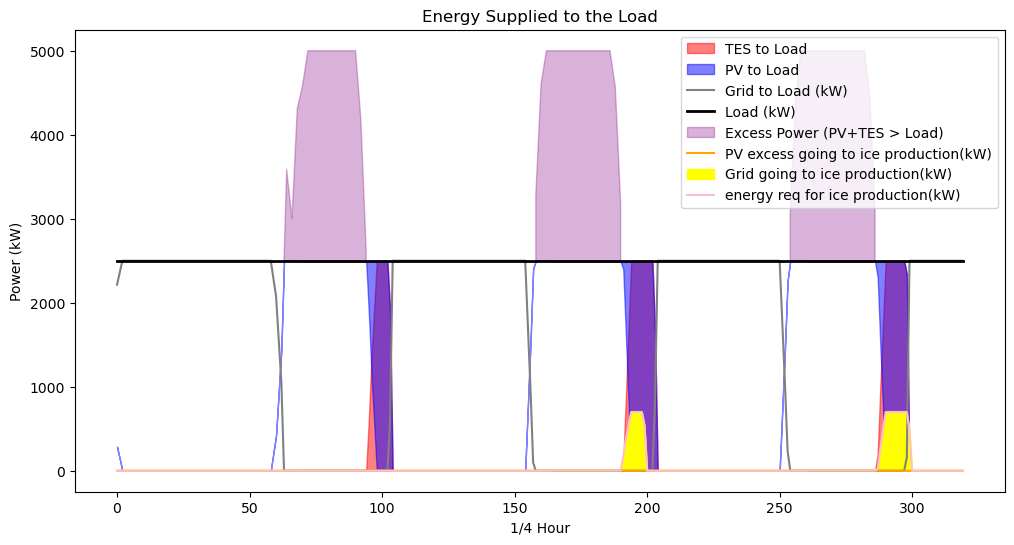

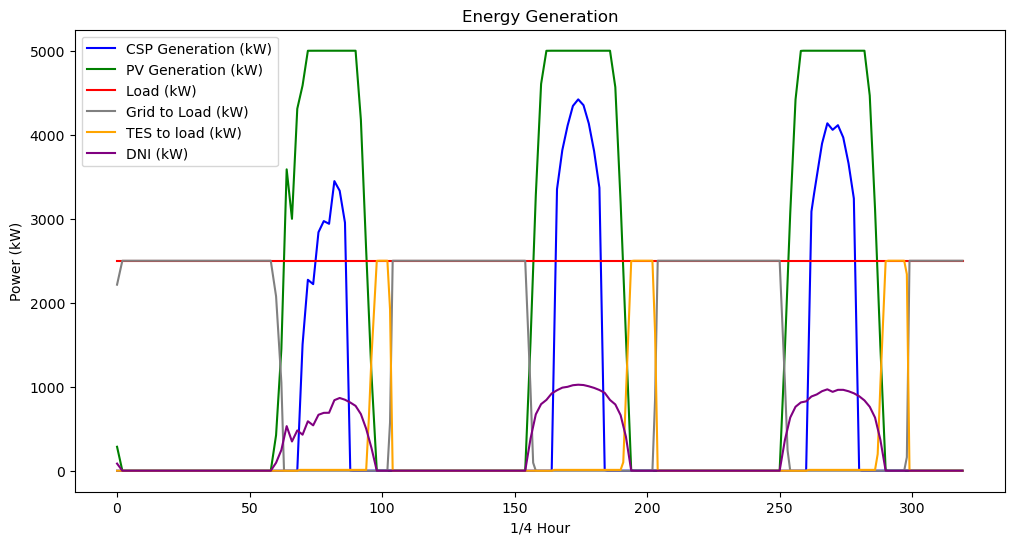

In [113]:
################################################################### Plotting ##########################################################################
display = 80*no_ts
plt.figure(figsize=(12, 6))
print(len(hrs),len(tes_to_grid))
plt.fill_between(hrs[0:display], 0, tes_to_grid[0:display], color='red', alpha=0.5, label='TES to Load')
plt.fill_between(hrs[0:display], pv_to_grid[0:display], combined_power_to_grid[0:display], color='blue', alpha=0.5, label='PV to Load')
plt.plot(hrs[0:display], grid_power_required[0:display], label='Grid to Load (kW)', color='gray')
plt.plot(hrs[0:display], load[0:display], label='Load (kW)', color='black', linewidth=2)
plt.fill_between(hrs[0:display], load[0:display], combined_power[0:display], where=(combined_power[0:display] > load[0:display]), color='purple', alpha=0.3, label='Excess Power (PV+TES > Load)')
plt.plot(hrs[0:display], pv_excess_contribution_to_ice_annual[0:display], label='PV excess going to ice production(kW)', color='orange')
plt.fill_between(hrs[0:display], grid_contribution_to_ice_annual[0:display], label='Grid going to ice production(kW)', color='yellow')
plt.plot(hrs[0:display], total_energy_req_for_ice[0:display], label='energy req for ice production(kW)', color='pink')


plt.xlabel(timeunit)
plt.ylabel('Power (kW)')
plt.title('Energy Supplied to the Load')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], CSP_gen[0:display], label='CSP Generation (kW)', color='blue')
plt.plot(hrs[0:display], hourly_pv_output[0:display], label='PV Generation (kW)', color='green')
plt.plot(hrs[0:display], load[0:display], label='Load (kW)', color='red')
plt.plot(hrs[0:display], grid_power_required[0:display], label='Grid to Load (kW)', color='gray')
plt.plot(hrs[0:display], tes_to_grid[0:display], label='TES to load (kW)', color='orange')
plt.plot(hrs[0:display], dni_data[0:display], label= 'DNI (kW)', color='purple')

plt.xlabel(timeunit)
plt.ylabel('Power (kW)')
plt.title('Energy Generation')
plt.legend()

"""plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], yearly_tes_stored[0:display], label='TES Stored Energy (kWh)', color='blue')
plt.xlabel(timeunit)
plt.ylabel('Stored Energy (kWh)')
plt.title('TES Stored Energy')
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], hourly_pv_output[0:display], label='pv ()', color='blue')
plt.xlabel(timeunit)
plt.ylabel(' ')
plt.title('PV annual output')
#"plt.legend()
plt.grid(True)"""

print(f"Percentage of the load met by the PV and TES system: {load_met_percentage:.2f}%")

In [86]:
#%% TEA Calculations 
combined_power_to_grid = pv_to_grid + tes_to_grid
total_power_to_grid = np.sum(combined_power_to_grid)
CAPEX = C_PV * PV_AC_Rating/1000 + C_TES * tes_capacity + C_PB * maximum_hourly_tes_output + C_CSP * n_collectors 

data = {'PV_AC_Rating': [PV_AC_Rating],
        'TES_capacity': [tes_capacity],
        'P_block': [maximum_hourly_tes_output],
        'CAPEX': [CAPEX],
        'PO': [total_power_to_grid],
        'load_met_percentage': [load_met_percentage]}
df = pd.DataFrame(data)

df[['LCOE','OM']] = df.apply(hybrid_tea_model_photon,axis=1,args=(C_OM_TES,C_OM_PV,C_OM_CSP,n,L,esc,DF,I,tax,COE,inflation,ITC,property_tax,insurance,MACRS_yrs,CAPEX),result_type='expand')
print('LCOE = '+str(np.round(float(df['LCOE']),3))+ ' $/kWh')

LCOE = 0.011 $/kWh
